Notes
- Do we want a column for date (or days since start)?
- Do we want to standardize by date? 
- The heck is happening with PC
- Can the last few days go in test?

In [127]:
import csv
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS

from statsmodels.tsa.tsatools import lagmat
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TSG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers 
import tensorflow as tf

ts_dir = '/Users/danielfriedman/Desktop/CS109b/final_project/timeseries/github/'
# ts_dir = '/Users/joannafriedman/Desktop/CS109b/final_project/timeseries/github/'
ts_dir = '/jupyteruser/31170133/timeseries'
os.chdir(ts_dir)

In [128]:
# # Only run if us_mobility.csv hasn't been created or needs updating 

# global_mob = pd.read_csv('../Global_Mobility_Report.csv', dtype = {'sub_region_2':object})
# mob = global_mob[global_mob['country_region'] == 'United States'].drop(columns = ['country_region_code','country_region'])
# mapper1 = {'sub_region_1':'state', 'sub_region_2':'county'}
# mapper2 = pd.Series(index = mob.columns[3:], data = ['retail','grocery','parks','transit','work','residential'])
# mob.rename(columns = mapper1, inplace = True)
# mob.rename(columns = mapper2, inplace = True)
# mob.loc[mob['state'] == 'District of Columbia', 'county'] = 'DC'
# mob = mob[(~pd.isnull(mob['state'])) & (~pd.isnull(mob['county']))].reset_index(drop = True)
# mob['county'] = mob.county.str.replace(' County', '')
# mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
# mob.to_csv('us_mobility.csv', index = False)

In [129]:
mob = pd.read_csv('data/us_mobility.csv')
mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
mob.head()


,state,county,date,retail,grocery,parks,transit,work,residential
0,Alabama,Autauga,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN
1,Alabama,Autauga,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN
2,Alabama,Autauga,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0
3,Alabama,Autauga,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0
4,Alabama,Autauga,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0


In [130]:
nyt = pd.read_csv(f'data/us-counties.csv').drop(columns = 'fips')
nyt['date'] = nyt['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
nyt['county'] = nyt.county.str.replace('City', '').str.strip()
nyt.head()

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [131]:
### TODO: match by county better
mobcounties = mob.county.unique()
nytcounties = nyt.county.unique()
print(len([c for c in mobcounties if c not in nytcounties]))
print(len([c for c in nytcounties if c not in mobcounties]))

198
148


In [132]:
mob = mob.merge(nyt, how = 'left', on = ['state','county','date'])
mob['cases'].fillna(0, inplace = True) # if it's nan, that means they hadn't had cases
mob['deaths'].fillna(0, inplace = True) # if it's nan, that means they hadn't had deaths

In [133]:
# Add in populations (when possible)
pop = pd.read_excel('data/pop.xlsx', header = 3, index_col = 0)\
    .reset_index()\
    .rename(columns = {'index':'loc','Census':'fips', 2019:'pop'})
pop = pop[(pop['loc'].str.contains('County')) & ~(pop['loc'].str.contains('Note'))][['loc','pop']]
pop['county'] = pop['loc'].str.split(' County,').apply(lambda x: x[0].replace('.',''))
pop['state'] = pop['loc'].str.split(' County, ').apply(lambda x: x[-1])
pop.drop(columns = 'loc', inplace = True)
mob = pd.merge(mob, pop, on = ['state','county'], how = 'left')
mob['casespc'] = 100000*mob['cases']/mob['pop'] # cases per 100k


In [134]:
# Decide whether to keep counties and columns based on response rates

# pick columns
cats = ['grocery','retail','work'] # note: only use these categories for building PCs
fullcats = ['grocery','parks','residential','retail','transit','work'] # other categories
mob.drop(columns = [col for col in fullcats if col not in cats], inplace = True)

# pick rows/counties
mob['ID'] = mob.groupby(['state','county']).ngroup() # assign each county an ID
missingrates = mob.groupby(['state','county','ID'])[cats].agg(lambda x: np.mean(pd.isnull(x))).reset_index() # missing rates by column for cats
allowance = 0.35 # what percent you're allowed to have missing without getting cut (check distplots of missingrates for reasonable cutoff)
keeper_IDs = missingrates.loc[(missingrates[cats] < allowance).sum(1) == 3, 'ID'].values # IDs of counties with all 3 under allowance
mob = mob[mob['ID'].isin(keeper_IDs)] # only keep those ones
mob.fillna(mob.groupby(['ID','state','county'])[cats].transform('median'), inplace = True) # fill in with median for group
mob = mob.loc[mob.groupby('ID')['casespc'].transform(lambda x: np.mean(pd.isnull(x))) == 0] # remove counties with missing cases pc
mob.reset_index(inplace = True, drop = True)



In [145]:
# divide
dates = mob.date.unique()
ndates = len(dates)
upto = dates[int(0.8*ndates)]
mobtest = mob[mob['date'] > upto]
mob = mob[mob['date'] <= upto]


#### Get metric of mobility

In [146]:
## Standardize
ss = SS().fit(mob[cats]) 
mobstand = ss.transform(mob[cats])
mobteststand = ss.transform(mobtest[cats])

In [147]:
## PCA
N_COMPONENTS = 1 
pca = PCA(n_components = N_COMPONENTS).fit(mobstand)
pcs = ['pc'+str(i) for i in range(N_COMPONENTS)]
mob[pcs] = pd.DataFrame(pca.transform(mobstand))
mobtest[pcs] = pd.DataFrame(pca.transform(mobteststand))
mob.head()

,state,county,date,retail,grocery,work,cases,deaths,pop,casespc,ID,pc0
0,Alabama,Autauga,2020-02-15,5.0,7.0,-4.0,0.0,0.0,55869.0,0.0,0,0.581848
1,Alabama,Autauga,2020-02-16,0.0,1.0,-4.0,0.0,0.0,55869.0,0.0,0,0.247541
2,Alabama,Autauga,2020-02-17,8.0,0.0,-27.0,0.0,0.0,55869.0,0.0,0,-0.414244
3,Alabama,Autauga,2020-02-18,-2.0,0.0,2.0,0.0,0.0,55869.0,0.0,0,0.382248
4,Alabama,Autauga,2020-02-19,-2.0,0.0,2.0,0.0,0.0,55869.0,0.0,0,0.382248


In [148]:
### This is weird. Try just averaging the standard ones? 
mob['pc0'] = mobstand.mean(1)
mobtest['pc0'] = mobteststand.mean(1)

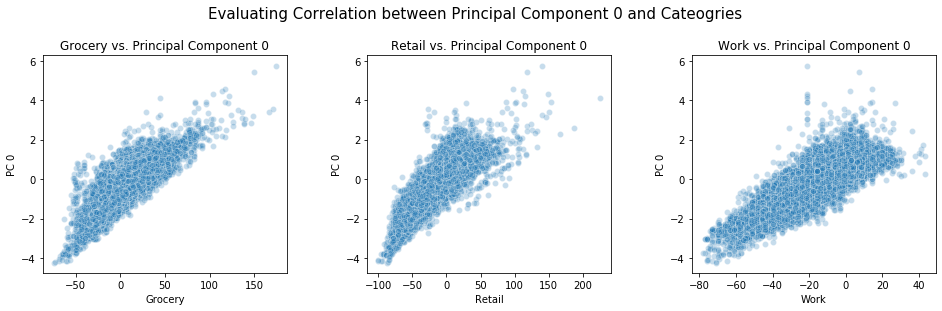

In [149]:
component = 0
fig, axes = plt.subplots(1, len(cats), figsize = (16,4))
for i, ax in enumerate(axes.ravel()):
    sns.scatterplot(mob[cats[i]], mob[f'pc{component}'], ax = ax, alpha = 0.25);
    ax.set(xlabel = cats[i].capitalize(),
           ylabel = 'PC '+str(component), 
           title = cats[i].capitalize() + ' vs. Principal Component ' + str(component))
fig.subplots_adjust(hspace = .33, wspace = .33);
fig.suptitle(f'Evaluating Correlation between Principal Component {component} and Cateogries', fontsize = 15, y = 1.05);

#### Baseline Model

In [150]:
predictors = pcs
target = 'casespc'
predictors = list(predictors) + [target]

In [151]:
nback = 10 # means each prediction will look back nback timesteps
nahead = 3 # means each prediction will be for up to nahead steps ahead
grouped = mob.groupby(['state','county','ID'])
county_lens = grouped.apply(len).values
nsamples = sum(np.maximum(county_lens - (nback + nahead - 1), 0)) # counts total number of samples we need # note that if it's shorter than nahead + nback, skip it 


In [152]:
# # only run the commented out stuff if X/y/states/counties aren't already saved
# X = np.empty((nsamples, nback, len(predictors)))
# y = np.empty((nsamples, nahead))
# states = []
# counties = []

# index = 0
# for (state, county, ID), data in grouped:
#     if len(data) < nback + nahead:
#         continue
#     for i in range(nback, len(data) - nahead + 1): 
#         X[index] = data.iloc[i-nback: i][predictors]
#         y[index] = data[target].iloc[i:i + nahead]
#         states.append(state)
#         counties.append(county)
#         index += 1
# states = np.array(states)
# counties = np.array(counties)

In [153]:
# np.savetxt(f'models/X{N_COMPONENTS}_{target}_forecasts.csv',X.reshape(nsamples, -1), delimiter = ',')
# np.savetxt(f'models/y{N_COMPONENTS}_{target}_forecasts.csv', y, delimiter = ',')
# np.savetxt(f'models/states{N_COMPONENTS}_{target}_forecasts.csv', states, delimiter = ',', fmt = '%s')
# np.savetxt(f'models/counties{N_COMPONENTS}_{target}_forecasts.csv', counties, delimiter = ',', fmt = '%s')

In [154]:
X = np.loadtxt(f'models/X{N_COMPONENTS}_{target}_forecasts.csv', delimiter = ',').reshape(nsamples, nback, len(predictors))
y = np.loadtxt(f'models/y{N_COMPONENTS}_{target}_forecasts.csv', delimiter = ',')
states = np.loadtxt(f'models/states{N_COMPONENTS}_{target}_forecasts.csv', delimiter = ',', dtype = str)
counties = np.loadtxt(f'models/counties{N_COMPONENTS}_{target}_forecasts.csv', delimiter = ',', dtype = str)

In [155]:
nunits = 500
interunits = 100
droprate = 0.15
optimizer = optimizers.Adam(learning_rate = 0.00001)

inputs = Input(shape = (nback, len(predictors)), name = 'inputs')
layer = LSTM(units = nunits, return_sequences = False, name = 'lstm1', activation = 'tanh')(inputs)
layer = Dropout(rate = droprate, name = 'drop1')(layer)
layer = Dense(interunits, activation = 'relu', name = 'inters')(layer)
outputs = Dense(nahead, activation = 'relu', name = 'outputs')(layer)
mod = Model(inputs, outputs, name = 'mod')
mod.compile(optimizer, loss = 'mean_squared_error')
mod.summary()

Model: "mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 10, 2)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 500)               1006000   
_________________________________________________________________
drop1 (Dropout)              (None, 500)               0         
_________________________________________________________________
inters (Dense)               (None, 100)               50100     
_________________________________________________________________
outputs (Dense)              (None, 3)                 303       
Total params: 1,056,403
Trainable params: 1,056,403
Non-trainable params: 0
_________________________________________________________________


In [156]:
epochs = 40
batch_size = 32
validation_split = 0.15
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2)]
verbose = 1

history = mod.fit(X,
                  y,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_split = validation_split,
                  callbacks = callbacks,
                  verbose = verbose)



Train on 60489 samples, validate on 10675 samples
Epoch 1/40
60489/60489 [==============================] - 22s 365us/sample - loss: 605.9428 - val_loss: 76.1365
Epoch 2/40
60489/60489 [==============================] - 18s 305us/sample - loss: 560.2241 - val_loss: 59.7335
Epoch 3/40
60489/60489 [==============================] - 19s 309us/sample - loss: 534.1473 - val_loss: 48.8661
Epoch 4/40
60489/60489 [==============================] - 19s 308us/sample - loss: 513.6601 - val_loss: 41.3152
Epoch 5/40
60489/60489 [==============================] - 19s 314us/sample - loss: 495.3247 - val_loss: 35.8018
Epoch 6/40
60489/60489 [==============================] - 19s 316us/sample - loss: 479.6085 - val_loss: 31.8930
Epoch 7/40
60489/60489 [==============================] - 20s 328us/sample - loss: 465.7115 - val_loss: 28.4184
Epoch 8/40
60489/60489 [==============================] - 20s 329us/sample - loss: 452.7213 - val_loss: 25.7198
Epoch 9/40
60489/60489 [==============================

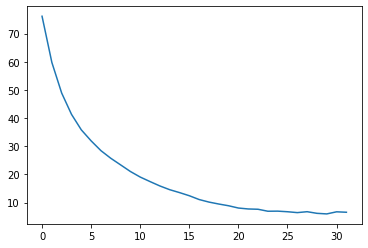

In [157]:
sns.lineplot(range(len(history.history['val_loss'])), history.history['val_loss']);

In [158]:
# mod.save(f'models/mod{N_COMPONENTS}_{target}_avgnotpc_and_forecasts.h5')  
# mod = load_model(f'models/mod{N_COMPONENTS}_{target}_avgnotpc_and_forecasts.h5')

In [159]:
yhat = mod.predict(X)

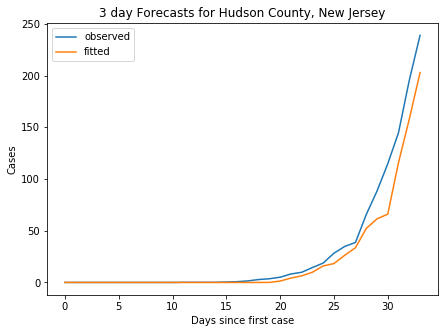

In [160]:
county = 'Hudson'
state = 'New Jersey'


countyy = y[(counties == county) & (states == state)]
countyyhat = yhat[(counties == county) & (states == state)]
county_obs = len(countyy)

fig, ax = plt.subplots(figsize = (7,5))
d = 2
sns.lineplot(range(county_obs), countyy[:,d], label = 'observed')
sns.lineplot(range(county_obs), countyyhat[:,d], label = 'fitted')
ax.set(xlabel = 'Days since first case', ylabel = 'Cases', title = f'{d + 1} day Forecasts for {county} County, {state}');




#### Tests

In [161]:
joint = mobtest.append(mob).sort_values(['ID','date'])
joint = joint[joint['date'] >= upto - np.timedelta64(nback - 1, 'D')] # only go to nback days before training ends (that way you're not predicitng any training)

# same thing but this time it's for joint
grouped = joint.groupby(['state','county','ID'])
county_lens = grouped.apply(len).values
nsamples = sum(np.maximum(county_lens - (nback + nahead - 1), 0)) # counts total number of samples we need # note that if it's shorter than nahead + nback, skip it 


In [164]:
# only run the commented out stuff if X/y/states/counties aren't already saved
Xtest = np.empty((nsamples, nback, len(predictors)))
ytest = np.empty((nsamples, nahead))
statestest = []
countiestest = []

index = 0
for (state, county, ID), data in grouped:
    if len(data) < nback + nahead:
        continue
    for i in range(nback, len(data) - nahead + 1): 
        Xtest[index] = data.iloc[i-nback: i][predictors]
        ytest[index] = data[target].iloc[i:i + nahead]
        statestest.append(state)
        countiestest.append(county)
        index += 1
statestest = np.array(statestest)
countiestest = np.array(countiestest)

In [165]:
yhattest = mod.predict(Xtest)

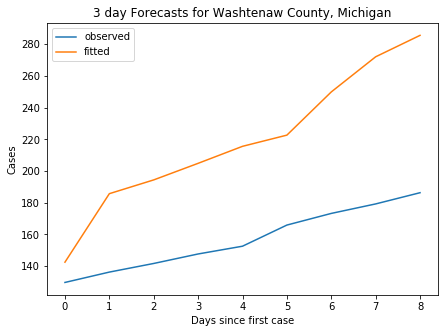

In [170]:
county = 'Hudson'
state = 'New Jersey'

county = 'Washtenaw'
state = 'Michigan'


countyy = ytest[(countiestest == county) & (statestest == state)]
countyyhat = yhattest[(countiestest == county) & (statestest == state)]
county_obs = len(countyy)

fig, ax = plt.subplots(figsize = (7,5))
d = 2
sns.lineplot(range(county_obs), countyy[:,d], label = 'observed')
sns.lineplot(range(county_obs), countyyhat[:,d], label = 'fitted')
ax.set(xlabel = 'Days since first case', ylabel = 'Cases', title = f'{d + 1} day Forecasts for {county} County, {state}');




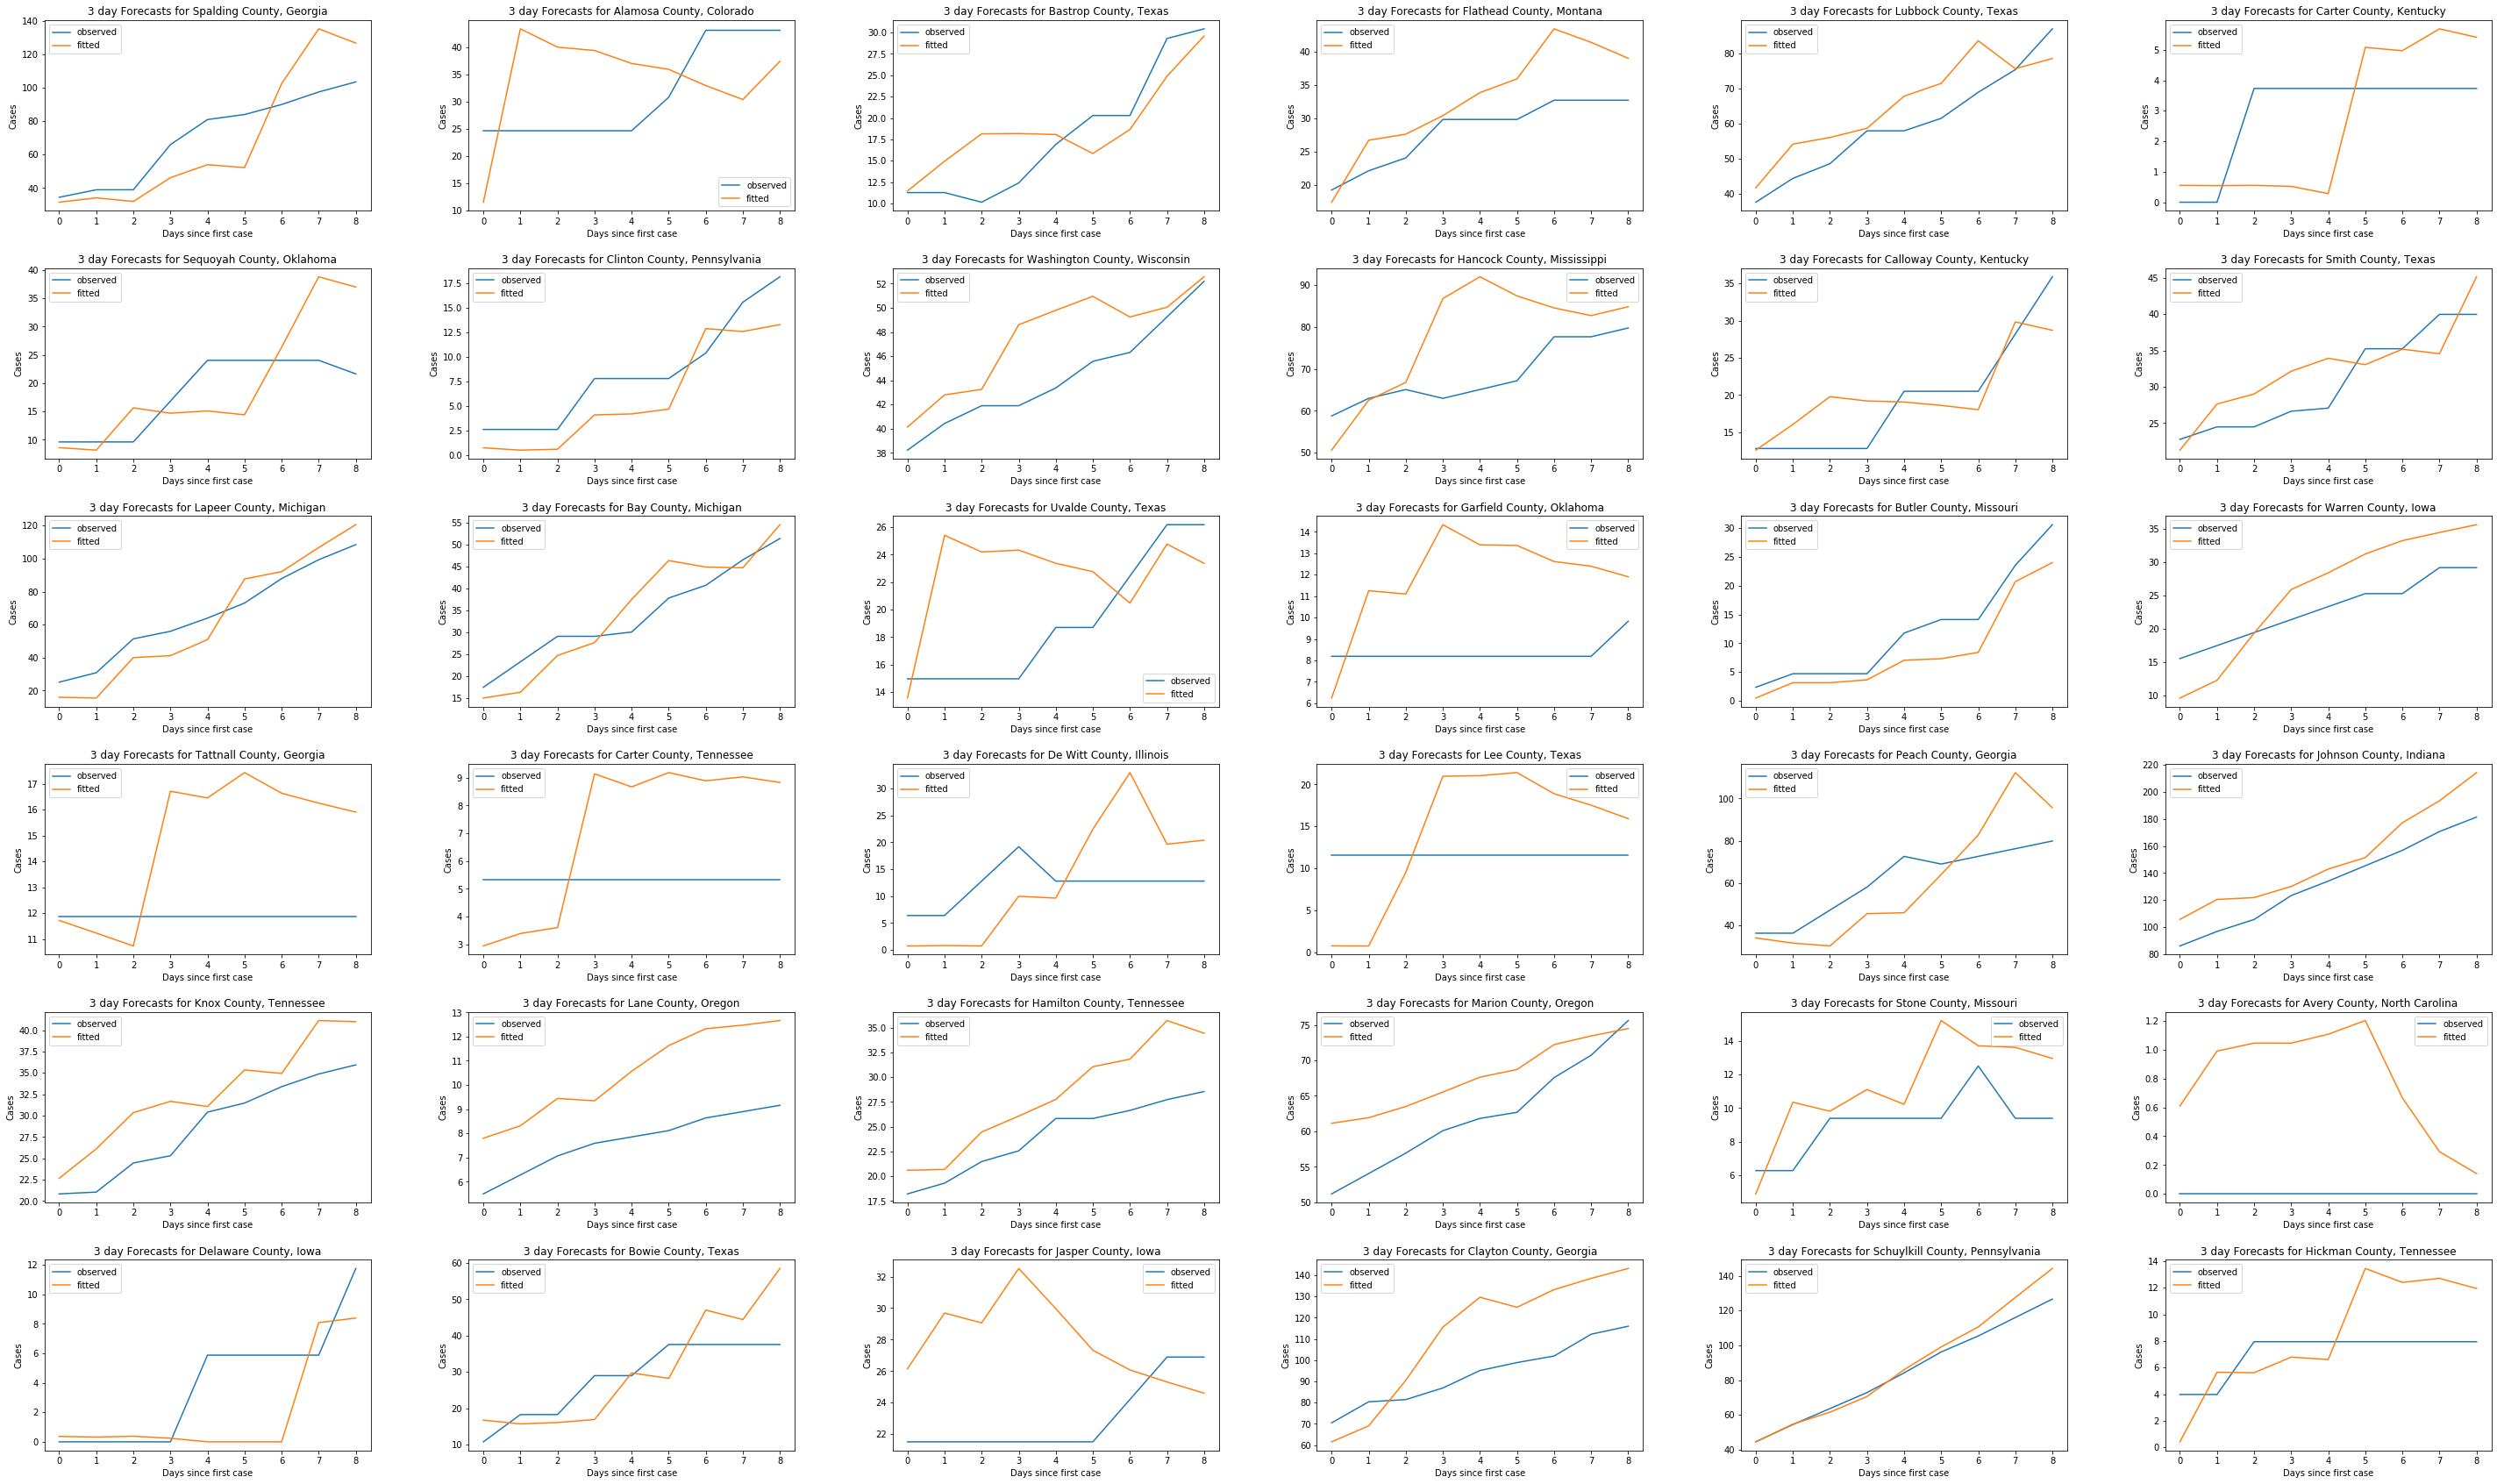

In [188]:
fig, ax = plt.subplots(6, 6, figsize = (50, 30))
indices = np.random.choice(np.arange(len(countiestest)), 36, replace = False)
d = 2

for i, ax in enumerate(ax.ravel()):
    
    county = countiestest[indices[i]]
    state = statestest[indices[i]]
    
    countyy = ytest[(countiestest == county) & (statestest == state)]
    countyyhat = yhattest[(countiestest == county) & (statestest == state)]
    county_obs = len(countyy)

    sns.lineplot(range(county_obs), countyy[:,d], label = 'observed', ax = ax)
    sns.lineplot(range(county_obs), countyyhat[:,d], label = 'fitted', ax = ax)
    ax.set(xlabel = 'Days since first case', ylabel = 'Cases', title = f'{d + 1} day Forecasts for {county} County, {state}');

plt.subplots_adjust(hspace = 0.3, wspace = 0.3)



#### Parameters that worked

- :O *** (consistent val loss around 300 for 1 PC, 300 for 2 PC, 300 for 3 PC)
    - units = 500
    - interunits = 32 or 100
    - droprate = 0.15
    - tanh, relu, relu (single LSTM layer)
    - lr = 0.00005 or lower 
    - ~10-15 epochs

#### Notes

- Standardize/centralize
- ~Add in other PCS!~
- change MACVAL —opposite effect as expected
- Lag/per capita
- Batch normalization
- batch size
- Change nback
- Add second LSTM layer and lower LR
- add NY back 
- log transfo
- toggle intermediate layer
- try without 0s